In [ ]:
import scipy.io as sciio
import numpy as np

bg = sciio.loadmat("PSF_bk.mat")
psf_bk = np.float32(bg["psf_bk"])

psf = list()
for i in [1550,1560,1570,1580,1590,1600]:
    img = sciio.loadmat("PSF0620_{}_04_4_40.mat".format(i))
    psf.append(np.float32(img["PSF0"]))

psf = np.array(psf, dtype="float")
print(np.max(psf), np.min(psf))
psf /= (np.max(psf) - np.min(psf))
psf = psf - np.min(psf)
print(psf.shape, np.max(psf), np.min(psf))
np.save("PSF0620_04_4_40.npy", psf[:, 140:140+256, 210:210+256])
np.save("PSF0620_04_4_40_bg.npy", psf_bk[140:140+256, 210:210+256])


转换点扩展函数，由matlab格式转为numpy格式

(256, 256, 6)


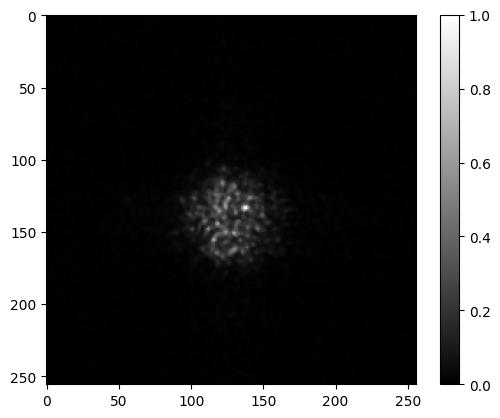

In [17]:
import scipy.io as sciio
import numpy as np
import matplotlib.pyplot as plt

psf_mat = sciio.loadmat("sup60/PSFset_Final.mat")
print(psf_mat["psf_set"].shape)
psf = psf_mat["psf_set"].transpose(2,0,1)
psf = np.array(psf, dtype="float")
psf /= (np.max(psf) - np.min(psf))
np.save("PSF0815_6_IR_60.npy",psf)


(6, 256, 256)
(256, 256)


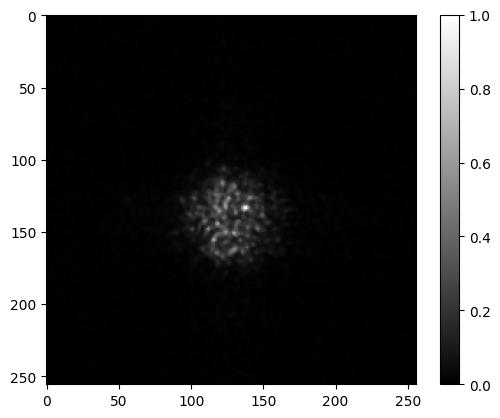

In [24]:
import matplotlib.pyplot as plt
import numpy as np 
psf = np.load("PSF0815_6_IR_60.npy")
psf_bg = np.load("PSF0620_04_4_40_bg.npy")
print(psf.shape)
print(psf_bg.shape)
plt.imshow(psf[5,:,:] ,cmap="gray")
plt.colorbar()

点扩散函数显示

In [45]:
import sys
sys.path.insert(0, "../src")
import matplotlib.pyplot as plt
import numpy as np
from lib.utils.PointSample import gen_merge_sample
import cv2

def fft_calc(point_source_plan,otf_3d ):

    point_source_fft = np.fft.fft2(np.fft.ifftshift(point_source_plan,(1,2)))
    otf_fft = np.fft.fft2(np.fft.ifftshift(otf_3d,(1,2)))

    fft_dot = np.multiply(point_source_fft, otf_fft)
    
    point_image = np.fft.ifft2(fft_dot)
    point_image = np.fft.fftshift(point_image,(1,2))
    point_image_amp = np.abs(point_image)

    Intensity = np.sum(point_image_amp,0)

    return Intensity

psf = np.load("PSF0620_04_4_40.npy")
labels = [0,1,2,3,4,5]
obj_width = 5

sample, target = gen_merge_sample(psf, labels, obj_width, point_type="ones_rand", weight_mode = "rand", have_noise = True , noise_sig = 0.01, nsr = 0.1)

rect_patch = np.load("rect_patchs.npy")
num, h, w = rect_patch.shape
print(target)


rect_patch = rect_patch / np.max(rect_patch) * 255

wave=[1550,1560,1570,1580,1590,1600]

for i in range(len(wave)):
    cv2.imwrite("rect_patch_{}.bmp".format(wave[i]), rect_patch[i, :, :])

sample /= np.max(sample)
cv2.imwrite("sample.bmp", sample[0, :, :]*255)



if False:

    print(psf.shape)
    psf = np.pad(psf,((0,0),(64,64),(64,64)))
    bg = np.zeros([num, 384, 384])
    bg[:, (192 - h // 2 - 1 ) : (192 + h // 2 ), (192 - w // 2 - 1) : (192 + w // 2)] = rect_patch

    point = np.zeros([num, 384, 384])

    for t in target:
        x = t[1]
        y = t[2]
        lenx = t[3]
        leny = t[4]
        point[:, (y - leny//2 - 1):(y + leny//2),  (x - lenx//2 - 1):(x + lenx//2)] = bg[:, (y - leny//2 - 1):(y + leny//2),  (x - lenx//2 - 1):(x + lenx//2)]
        bg[:, (y - leny//2 - 1):(y + leny//2),  (x - lenx//2 - 1):(x + lenx//2)] = 0


    a = point[0, (192 - h // 2 - 1 ) : (192 + h // 2 ), (192 - w // 2 - 1) : (192 + w // 2) ]
    plt.imshow(a, cmap="gray")
    cv2.imwrite("pt.bmp", a / np.max(a) * 255)

    rect_patch[:, (h//2 - 3): (h//2 + 2) , (w//2- 3 - 1) : (w//2 + 2) ] = 0
    b = rect_patch[0,:,:]
    cv2.imwrite("rect.bmp", b / np.max(b) * 255)
    plt.show()


    print(np.max(point), np.min(point))
    I_pt = fft_calc(point, psf)
    I_bg = fft_calc(bg, psf)
    print(np.max(I_pt))
    plt.imshow(I_pt, cmap="gray")
    plt.axis("off")
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=16) 
    plt.show()


    plt.imshow(I_bg, cmap="gray")
    plt.axis("off")
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=16) 
    plt.show()

    plt.imshow(I_pt +I_bg , cmap="gray")
    plt.colorbar()
    plt.show()


[[5, 183, 150, 5, 5, 0.022123224442398923, 0.6755391207605753, 0.5963590950706972, 0.9642104179696754, 0.2655576425766682, 1.0, 192, 192], [3, 211, 180, 5, 5, 0.5547165207467304, 0.5810038711515273, 0.1630560271798264, 1.0, 0.23278953794435556, 0.8930941260686448, 192, 192]]


In [27]:
import numpy as np
psf = np.load("PSF0620_04_4_40.npy")
x = 64
psf = psf[:, (128 - x):(128 + x), (128 - x):(128 + x)]
psf = np.reshape(psf,(6, 4 * x * x))
coff = np.corrcoef(psf,rowvar=True)
np.savetxt("PSF0620_04_4_40.txt", coff)
print(coff)
print(coff>0.9)

[[1.         0.50781588 0.70069417 0.53651497 0.79377039 0.51421383]
 [0.50781588 1.         0.78733786 0.93221731 0.65577386 0.92612092]
 [0.70069417 0.78733786 1.         0.81339362 0.82447818 0.78462866]
 [0.53651497 0.93221731 0.81339362 1.         0.68134336 0.96086091]
 [0.79377039 0.65577386 0.82447818 0.68134336 1.         0.64238449]
 [0.51421383 0.92612092 0.78462866 0.96086091 0.64238449 1.        ]]
[[ True False False False False False]
 [False  True False  True False  True]
 [False False  True False False False]
 [False  True False  True False  True]
 [False False False False  True False]
 [False  True False  True False  True]]
